In [4]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

## 1. 합성곱 오토인코더

#### 이미지를 다루고, 이미지의 크기가 작지 않은 경우에는 보통의 오토인코더보다 인코더/디코더 위치에 합성곱을 사용한 합성곱 오토인코더가 유용할 수 있다.

In [18]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2842 - val_rounded_accuracy: 0.9302
Epoch 2/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2708 - rounded_accuracy: 0.9463 - val_loss: 0.2697 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2682 - rounded_accuracy: 0.9491 - val_loss: 0.2685 - val_rounded_accuracy: 0.9493
Epoch 5/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2670 - val_rounded_accuracy: 0.9511


In [19]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)         

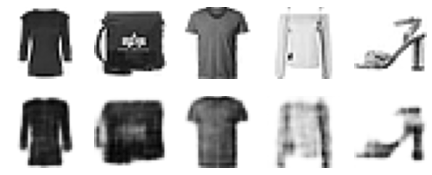

In [20]:
show_reconstructions(conv_ae)
plt.show()

## 2. 순환 오토인코더

#### 시계열/텍스트와 같은 시퀀스에 대해서는 순환 오토인코더가 유용할 수 있다.

In [21]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [22]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 10ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.4050 - rounded_accuracy: 0.8433 - val_loss: 0.3744 - val_rounded_accuracy: 0.8683
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3603 - val_rounded_accuracy: 0.8766
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8771
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3361 - val_rounded_accuracy: 0.8922
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3334 - rounded_accuracy: 0.8922 - val_loss: 0.3306 - val_rounded_accuracy: 0.8964
Epoch 7/10
1719/1719 [========

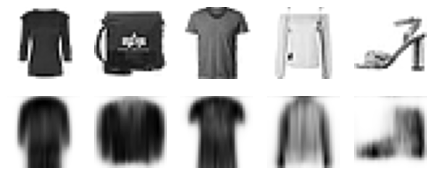

In [23]:
show_reconstructions(recurrent_ae)
plt.show()

## 3. 적층 잡음 제거 오토인코더

#### 오토인코더가 유용한 특성을 학습하도록 하기 위해서 입력에 적절한 잡음(드롭아웃/가우시안 노이즈 등)을 추가하고, 잡음이 없는 입력을 복원하도록 하는 것이 효율적.

###### 가우시안노이즈 사용

In [24]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3469 - rounded_accuracy: 0.8801 - val_loss: 0.3170 - val_rounded_accuracy: 0.9081
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3113 - rounded_accuracy: 0.9106 - val_loss: 0.3062 - val_rounded_accuracy: 0.9171
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3041 - rounded_accuracy: 0.9168 - val_loss: 0.3022 - val_rounded_accuracy: 0.9172
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3003 - rounded_accuracy: 0.9201 - val_loss: 0.2979 - val_rounded_accuracy: 0.9244
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9225 - val_loss: 0.2954 - val_rounded_accuracy: 0.9256
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2954 - rounded_accuracy: 0.9244 - val_loss: 0.2932 - val_rounded_accuracy: 0.9290
Epoch 7/10
1719/1719 [==================

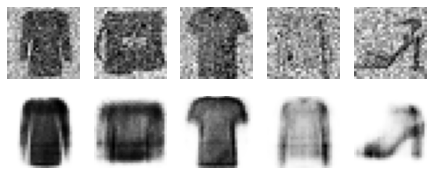

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

###### 드롭아웃 사용

In [26]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3556 - rounded_accuracy: 0.8712 - val_loss: 0.3202 - val_rounded_accuracy: 0.9040
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3177 - rounded_accuracy: 0.9036 - val_loss: 0.3105 - val_rounded_accuracy: 0.9112
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3117 - rounded_accuracy: 0.9083 - val_loss: 0.3064 - val_rounded_accuracy: 0.9155
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3081 - rounded_accuracy: 0.9111 - val_loss: 0.3033 - val_rounded_accuracy: 0.9186
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3057 - rounded_accuracy: 0.9131 - val_loss: 0.3010 - val_rounded_accuracy: 0.9197
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9147 - val_loss: 0.3001 - val_rounded_accuracy: 0.9188
Epoch 7/10
1719/1719 [==================

그림 저장 dropout_denoising_plot


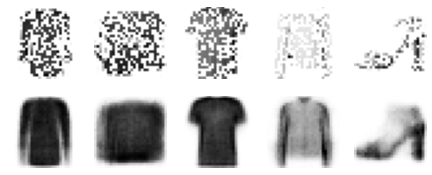

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

## 4. 희소 오토인코더

###### 일반적인 오토인코더

In [28]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4302 - rounded_accuracy: 0.7967 - val_loss: 0.3750 - val_rounded_accuracy: 0.8510
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3563 - rounded_accuracy: 0.8725 - val_loss: 0.3460 - val_rounded_accuracy: 0.8852
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3359 - rounded_accuracy: 0.8905 - val_loss: 0.3308 - val_rounded_accuracy: 0.8952
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3238 - rounded_accuracy: 0.9006 - val_loss: 0.3222 - val_rounded_accuracy: 0.9025
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9047 - val_loss: 0.3182 - val_rounded_accuracy: 0.9053
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3146 - rounded_accuracy: 0.9078 - val_loss: 0.3147 - val_rounded_accuracy: 0.9086
Epoch 7/10
1719/1719 [==================

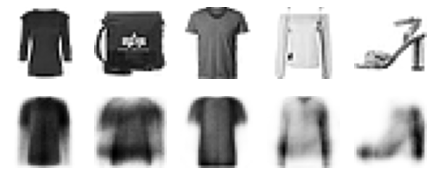

In [29]:
show_reconstructions(simple_ae)
plt.show()

###### $\ell_1$ 규제를 추가한 희소 오토인코더

In [30]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4312 - rounded_accuracy: 0.8123 - val_loss: 0.3814 - val_rounded_accuracy: 0.8528
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3692 - rounded_accuracy: 0.8689 - val_loss: 0.3642 - val_rounded_accuracy: 0.8756
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3549 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8845
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3441 - rounded_accuracy: 0.8873 - val_loss: 0.3441 - val_rounded_accuracy: 0.8916
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8914 - val_loss: 0.3381 - val_rounded_accuracy: 0.8935
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3334 - rounded_accuracy: 0.8954 - val_loss: 0.3327 - val_rounded_accuracy: 0.8974
Epoch 7/10
1719/1719 [==================

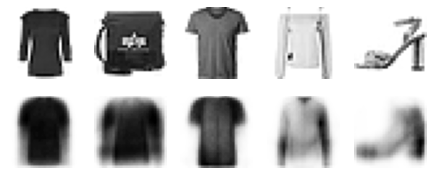

In [31]:
show_reconstructions(sparse_l1_ae)

## 5. 변이형 오토인코더

### 일반적인 오토인코더와의 차이점
#### 1. 훈련이 끝난 후에도 출력이 부분적으로 확률적으로 결정됨
#### 2. 생성 오토인코더 : 마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있다

### 크게 세 부분으로 구성됨 인코더 -> latent space -> 디코더
### 인코더에서는 주어진 input을 가우시안 공간으로 밀어넣는 가중치 학습. 이후 계산된 가우시안 공간에서 mean과 var을 계산해 latent space에 넘겨줌
### latent space에서는 넘겨받은 가우시안 공간에서 코딩을 샘플링하여 디코더에 넘겨줌
### 디코더에서는 latent space에서 넘겨받은 샘플링된 코딩을 사용해 기존의 오토인코더에서 디코더가 수행했던 작업을 동일하게 수행

In [6]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [12]:
codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 7s 9ms/step - loss: 0.3846 - rounded_accuracy: 0.8656 - val_loss: 0.3554 - val_rounded_accuracy: 0.8915
Epoch 2/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3419 - rounded_accuracy: 0.8988 - val_loss: 0.3371 - val_rounded_accuracy: 0.9057
Epoch 3/25
430/430 [==============================] - 5s 12ms/step - loss: 0.3320 - rounded_accuracy: 0.9057 - val_loss: 0.3294 - val_rounded_accuracy: 0.9085
Epoch 4/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3270 - rounded_accuracy: 0.9096 - val_loss: 0.3269 - val_rounded_accuracy: 0.9128
Epoch 5/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3240 - rounded_accuracy: 0.9121 - val_loss: 0.3284 - val_rounded_accuracy: 0.9092
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3219 - rounded_accuracy: 0.9137 - val_loss: 0.3217 - val_rounded_accuracy: 0.9154
Epoch 7/25
430/430 [==============================]

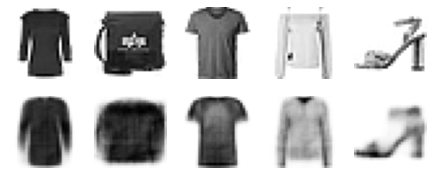

In [13]:
show_reconstructions(variational_ae)
plt.show()

### 5-1. 변이형 오토인코더를 활용해 새로운 패션 MNIST 이미지 생성하기

In [14]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

그림 저장 vae_generated_images_plot


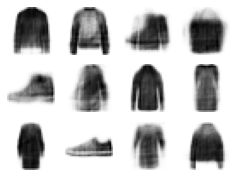

In [15]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

#### 보간 수행

그림 저장 semantic_interpolation_plot


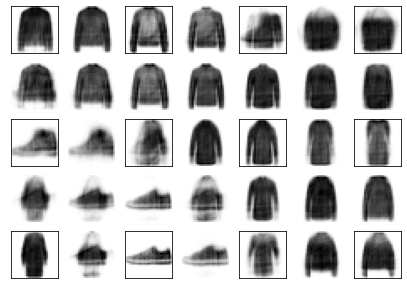

In [16]:
codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)